https://github.com/EbTech/AutoODE-DSL/blob/main/notebooks/Epidemic_models.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dataclasses import dataclass

from typing import List

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import grad

# plt.rc("text", usetex=True)
# plt.rc("font", size=15, family="serif")
%matplotlib inline

In [11]:
@dataclass
class SEVIRDT:
    L: float = 0.07143  # Natural birth rate
    beta: float = 0.8  # Transmission rate 
    kappa: float = 0.21739  # Efficacy in preventing covid19 infection of vaccine
    alpha: float = 0.10526  # Overal rate of vaccination
    q: float = 0.0016  # Proportion vaccinated
    sigma: float = 0.0255  # Fraction of exposed individuals moving to infected
    gamma: float = 0.2  # Recovery rate
    gamma_vax: float = 0.09901  # Recovery rate of individuals vaccinated
    delta: float = 0.0255  # Death rate due to covid19
    mu: float = 0.00553  # Natural death rate
    t12: float = 0.1
    t21: float = 0.1
    
    def __init__(self, N1, N2):
        self.N1 = N1
        self.N2 = N2
    
    @property
    def names(self) -> List[str]:
        return ["S1", "E1", "V1", "I1", "R1", "D1", "S2", "E2", "V2", "I2", "R2", "D2"]

    def derivs(self, time: float, variables: np.ndarray):
        S1, E1, V1, I1, R1, D1, S2, E2, V2, I2, R2, D2 = variables
        dS1 = self.L * self.N1 - self.beta * S1 * I1 / self.N1 - (self.mu + self.alpha) * S1  + self.t21 * S2 - self.t12 * S1
        dE1 = self.beta * I1 * (S1 + ( 1 - self.kappa) * V1) / self.N1 - (self.sigma + self.mu) * E1 + self.t21 * E2 - self.t12 * E1
        dV1 = self.alpha * self.q * S1 - self.beta * (1 - self.kappa) * V1 * I1 / self.N1 - (self.gamma_vax + self.mu) * V1 + self.t21 * V2 - self.t12 * V1
        dI1 = self.sigma * E1 - (self.gamma + self.delta) * I1 - self.mu * I1 + self.t21 * I2 - self.t12 * I1
        dR1 = self.gamma * I1 + self.gamma_vax * V1 - self.mu * R1 + self.t21 * R2 - self.t12 * R1
        dD1 = self.delta * I1 + self.t21 * D2 - self.t12 * D1
        dS2 = self.L * self.N2 - self.beta * S2 * I2 / self.N2 - (self.mu + self.alpha) * S2 + self.t12 * S1 - self.t21 * S2
        dE2 = self.beta * I2 * (S2 + ( 1 - self.kappa) * V2) / self.N2 - (self.sigma + self.mu) * E2 + self.t12 * E1 - self.t21 * E2
        dV2 = self.alpha * self.q * S2 - self.beta * (1 - self.kappa) * V2 * I2 / self.N2 - (self.gamma_vax + self.mu) * V2 + self.t12 * V1 - self.t21 * V2
        dI2 = self.sigma * E2 - (self.gamma + self.delta) * I2 - self.mu * I2 + self.t12 * I1 - self.t21 * I2
        dR2 = self.gamma * I2 + self.gamma_vax * V2 - self.mu * R2 + self.t12 * R1 - self.t21 * R2
        dD2 = self.delta * I2 + self.t12 * D1 - self.t21 * D2
        return np.array([dS1, dE1, dV1, dI1, dR1, dD1, dS2, dE2, dV2, dI2, dR2, dD2])

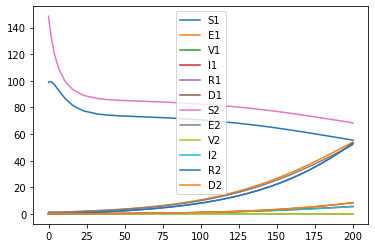

In [12]:
N1 = 100.
N2 = 150.
model = SEVIRDT(N1, N2)
start = [N1 * 0.99, N1 * 0.01, 0, 0, 0, 0, N2 * 0.99, N2 * 0.01, 0, 0, 0, 0]
t_span = (0, 200)
result = solve_ivp(model.derivs, t_span, start)

t = result.t
variables = result.y

for v, name in zip(variables, model.names):
    plt.plot(t, v, label=name)
plt.legend()

## DINN

In [ ]:
S_data = variables[0, :]
E_data = variables[1, :]
V_data = variables[2, :]
I_data = variables[3, :]
R_data = variables[4, :]
D_data = variables[5, :]

In [ ]:
class DINN(nn.Module):
    def __init__(self, N, t, S_data, E_data, V_data, I_data, R_data, D_data):
        super(DINN, self).__init__()
        
        self.N = N #population size
        
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t), 1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.S = torch.tensor(S_data)
        self.E = torch.tensor(E_data)
        self.V = torch.tensor(V_data)
        self.I = torch.tensor(I_data)
        self.R = torch.tensor(R_data)
        self.D = torch.tensor(D_data)
        self.losses = [] # here I saved the model's losses per epoch

        #setting the parameters
        self.L_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.kappa_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.sigma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_vax_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.delta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #find values for normalization
        self.S_max = max(self.S)
        self.E_max = max(self.E)
        self.V_max = max(self.V)
        self.I_max = max(self.I)
        self.R_max = max(self.R)
        self.D_max = max(self.D)

        self.S_min = min(self.S)
        self.E_min = min(self.E)
        self.V_min = min(self.V)
        self.I_min = min(self.I)
        self.R_min = min(self.R)
        self.D_min = min(self.D)

        #normalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)        
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)

        #matrices (x6 for S,E,V,I,R,D) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 4)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 4)); self.m6[:, 5] = 1
        
        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(
            list(
                [
                    self.L_tilda,
                    self.beta_tilda,
                    self.kappa_tilda,
                    self.alpha_tilda,
                    self.q_tilda,
                    self.sigma_tilda,
                    self.gamma_tilda,
                    self.gamma_vax_tilda,
                    self.delta_tilda,
                    self.mu_tilda
                ]
            )
        )

########################        
#### HERE  ####
################
    #force parameters to be in a range
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) #* 0.1 + 0.2

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda) #* 0.01 + 0.05
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda) #* 0.01 + 0.03

    class Net_sidr(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps 
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, D, R (100 S, 100 I, 100 D, 100 R --- since we have a batch of 100 timesteps)

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr

    def net_f(self, t_batch):
            
            #pass the timesteps batch to the neural network
            sidr_hat = self.net_sidr(t_batch)
            
            #organize S,I,D,R from the neural network's output -- note that these are normalized values -- hence the "hat" part
            S_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3]

            #S_t
            sidr_hat.backward(self.m1, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I_t
            sidr_hat.backward(self.m2, retain_graph=True)
            I_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #D_t
            sidr_hat.backward(self.m3, retain_graph=True)
            D_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            sidr_hat.backward(self.m4, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_() 

            #unnormalize
            S = self.S_min + (self.S_max - self.S_min) * S_hat
            I = self.I_min + (self.I_max - self.I_min) * I_hat
            D = self.D_min + (self.D_max - self.D_min) * D_hat      
            R = self.R_min + (self.R_max - self.R_min) * R_hat        

            f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
            f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
            f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
            f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)        

            return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat

    def train(self, n_epochs):
        # train
        print('\nstarting training...\n')
        
        for epoch in range(n_epochs):
            # lists to hold the output (maintain only the final epoch)
            S_pred_list = []
            I_pred_list = []
            D_pred_list = []
            R_pred_list = []

            # we pass the timesteps batch into net_f
            f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch) # net_f outputs f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
            
            self.optimizer.zero_grad() #zero grad
            
            #append the values to plot later (note that we unnormalize them here for plotting)
            S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
            I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
            D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
            R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

            #calculate the loss --- MSE of the neural networks output and each compartment
            loss = (torch.mean(torch.square(self.S_hat - S_pred))+ 
                    torch.mean(torch.square(self.I_hat - I_pred))+
                    torch.mean(torch.square(self.D_hat - D_pred))+
                    torch.mean(torch.square(self.R_hat - R_pred))+
                    torch.mean(torch.square(f1))+
                    torch.mean(torch.square(f2))+
                    torch.mean(torch.square(f3))+
                    torch.mean(torch.square(f4))
                    ) 

            loss.backward()
            self.optimizer.step()
            self.scheduler.step() 

            # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
            self.losses.append(loss.item())

            if epoch % 1000 == 0:          
                print('\nEpoch ', epoch)
                print('alpha: (goal 0.191 ', self.alpha)
                print('beta: (goal 0.05 ', self.beta)
                print('gamma: (goal 0.0294 ', self.gamma)
                print('#################################')                

        return S_pred_list, I_pred_list, D_pred_list, R_pred_list

In [ ]:
dinn = DINN(
    data[0],
    data[1],
    data[2],
    data[3], 
    data[4]
) #in the form of [t,S,I,D,R]

learning_rate = 1e-6
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(
    dinn.optimizer,
    base_lr=1e-5, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(50000) #train

In [ ]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss'),

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

ax.plot(data[0], data[1], 'pink', alpha=1, lw=2, label='Susceptible')
ax.scatter(data[0], S_pred_list[0].detach().numpy(), color='red', marker=".", alpha=1 , label='Susceptible Prediction')

ax.plot(data[0], data[2], 'violet', alpha=1, lw=2, label='Infected')
ax.scatter(data[0], I_pred_list[0].detach().numpy(), color='dodgerblue', alpha=1, marker=".", label='Infected Prediction')

ax.plot(data[0], data[3], 'darkgreen', alpha=0.5, lw=2, label='Dead')
ax.scatter(data[0], D_pred_list[0].detach().numpy(), color='green', alpha=1, marker=".", label='Dead Prediction')

ax.plot(data[0], data[4], 'blue', alpha=0.5, lw=2, label='Recovered')
ax.scatter(data[0], R_pred_list[0].detach().numpy(), color='teal', alpha=1, marker=".", label='Recovered Prediction')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(visible=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()